# Final Project For Online Course DS and ML for Python

## Predict whether a mammogram mass is benign or malignant

We'll be using the "mammographic masses" public dataset from the UCI repository (source: https://archive.ics.uci.edu/ml/datasets/Mammographic+Mass)

This data contains 961 instances of masses detected in mammograms, and contains the following attributes:

| Attribute name | Description 
| --------------| ---------------------------|
| BI-RADS assessment| 1 to 5 (ordinal) 
| Age | patient's age in years (integer)
| Shape | mass shape: round=1 oval=2 lobular=3 irregular=4 (nominal)
| Margin | mass margin: circumscribed=1 microlobulated=2 obscured=3 ill-defined=4 spiculated=5 (nominal)
| Density | mass density high=1 iso=2 low=3 fat-containing=4 (ordinal)
| Severity | benign=0 or malignant=1 (binominal)

   
BI-RADS is an assesment of how confident the severity classification is; it is not a "predictive" attribute and so we will discard it. The age, shape, margin, and density attributes are the features that we will build our model with, and "severity" is the classification we will attempt to predict based on those attributes.

Although "shape" and "margin" are nominal data types, which sklearn typically doesn't deal with well, they are close enough to ordinal that we shouldn't just discard them. The "shape" for example is ordered increasingly from round to irregular.

A lot of unnecessary anguish and surgery arises from false positives arising from mammogram results. If we can build a better way to interpret them through supervised machine learning, it could improve a lot of lives.

## Your assignment

Apply several different supervised machine learning techniques to this data set, and see which one yields the highest accuracy as measured with K-Fold cross validation (K=10). Apply:

* Decision tree
* Random forest
* KNN
* Naive Bayes
* SVM
* Logistic Regression
* And, as a bonus challenge, a neural network using Keras.

The data needs to be cleaned; many rows contain missing data, and there may be erroneous data identifiable as outliers as well.

Remember some techniques such as SVM also require the input data to be normalized first.

Many techniques also have "hyperparameters" that need to be tuned. Once you identify a promising approach, see if you can make it even better by tuning its hyperparameters.

I was able to achieve over 80% accuracy - can you beat that?


## Let's begin: prepare your data


In [14]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
masses_data = pd.read_csv('data/mammographic_masses.data.txt', na_values=['?'], 
                          names = ['BI-RADS', 'age', 'shape', 'margin', 'density', 'severity'])
masses_data.head()

,BI-RADS,age,shape,margin,density,severity
0,5.0,67.0,3.0,5.0,3.0,1
1,4.0,43.0,1.0,1.0,NaN,1
2,5.0,58.0,4.0,5.0,3.0,1
3,4.0,28.0,1.0,1.0,3.0,0
4,5.0,74.0,1.0,5.0,NaN,1


## Inspect the data

In [4]:
masses_data.describe()

,BI-RADS,age,shape,margin,density,severity
count,959.000000,956.000000,930.000000,913.000000,885.000000,961.000000
mean,4.348279,55.487448,2.721505,2.796276,2.910734,0.463059
std,1.783031,14.480131,1.242792,1.566546,0.380444,0.498893
min,0.000000,18.000000,1.000000,1.000000,1.000000,0.000000
25%,4.000000,45.000000,2.000000,1.000000,3.000000,0.000000
50%,4.000000,57.000000,3.000000,3.000000,3.000000,0.000000
75%,5.000000,66.000000,4.000000,4.000000,3.000000,1.000000
max,55.000000,96.000000,4.000000,5.000000,4.000000,1.000000


There are quite a few missing values in the data set. It's best to inspect if there are any correlation to the missing data.

In [5]:
masses_data.loc[(masses_data['age'].isnull()) |
              (masses_data['shape'].isnull()) |
              (masses_data['margin'].isnull()) |
              (masses_data['density'].isnull())]

,BI-RADS,age,shape,margin,density,severity
1,4.0,43.0,1.0,1.0,NaN,1
4,5.0,74.0,1.0,5.0,NaN,1
5,4.0,65.0,1.0,NaN,3.0,0
6,4.0,70.0,NaN,NaN,3.0,0
7,5.0,42.0,1.0,NaN,3.0,0
...,...,...,...,...,...,...
778,4.0,60.0,NaN,4.0,3.0,0
819,4.0,35.0,3.0,NaN,2.0,0
824,6.0,40.0,NaN,3.0,4.0,1
884,5.0,NaN,4.0,4.0,3.0,1


The missing data is randomly distributed. Now we can drop the the missing value instead of filling it.

In [6]:
masses_data.dropna(inplace=True)
masses_data.describe()

,BI-RADS,age,shape,margin,density,severity
count,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000
mean,4.393976,55.781928,2.781928,2.813253,2.915663,0.485542
std,1.888371,14.671782,1.242361,1.567175,0.350936,0.500092
min,0.000000,18.000000,1.000000,1.000000,1.000000,0.000000
25%,4.000000,46.000000,2.000000,1.000000,3.000000,0.000000
50%,4.000000,57.000000,3.000000,3.000000,3.000000,0.000000
75%,5.000000,66.000000,4.000000,4.000000,3.000000,1.000000
max,55.000000,96.000000,4.000000,5.000000,4.000000,1.000000


## Prepare data for ML

In [7]:
# Use (age, shape, margin, density) as features for our model
feature_names = ['age', 'shape', 'margin', 'density']
features_value = masses_data[['age', 'shape','margin', 'density']].values

# Use sevirity as Class
classes = masses_data['severity'].values
features_value

array([[67.,  3.,  5.,  3.],
       [58.,  4.,  5.,  3.],
       [28.,  1.,  1.,  3.],
       ...,
       [64.,  4.,  5.,  3.],
       [66.,  4.,  5.,  3.],
       [62.,  3.,  3.,  3.]])

Some of our models require the input data to be normalized, so I use 'preprocessing.StandardScaler()' to normalize the attribute data

In [8]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()
features_value_scaled = scaler.fit_transform(features_value)
features_value_scaled

array([[ 0.7650629 ,  0.17563638,  1.39618483,  0.24046607],
       [ 0.15127063,  0.98104077,  1.39618483,  0.24046607],
       [-1.89470363, -1.43517241, -1.157718  ,  0.24046607],
       ...,
       [ 0.56046548,  0.98104077,  1.39618483,  0.24046607],
       [ 0.69686376,  0.98104077,  1.39618483,  0.24046607],
       [ 0.42406719,  0.17563638,  0.11923341,  0.24046607]])

## Decision Trees

Before moving to K-Fold cross validation and random forests, start by creating a single train/test split of our data. Set aside 75% for training, and 25% for testing.

In [9]:
import numpy
from sklearn.model_selection import train_test_split

numpy.random.seed(1)
X_train, X_test, y_train, y_test = train_test_split(features_value_scaled, classes, train_size=0.75, random_state=1)

Now create a DecisionTreeClassifier and fit it to your training data.

In [10]:
from sklearn.tree import DecisionTreeClassifier

clf= DecisionTreeClassifier(random_state=1)

# Train the classifier on the training set
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1)

Display the resulting decision tree.

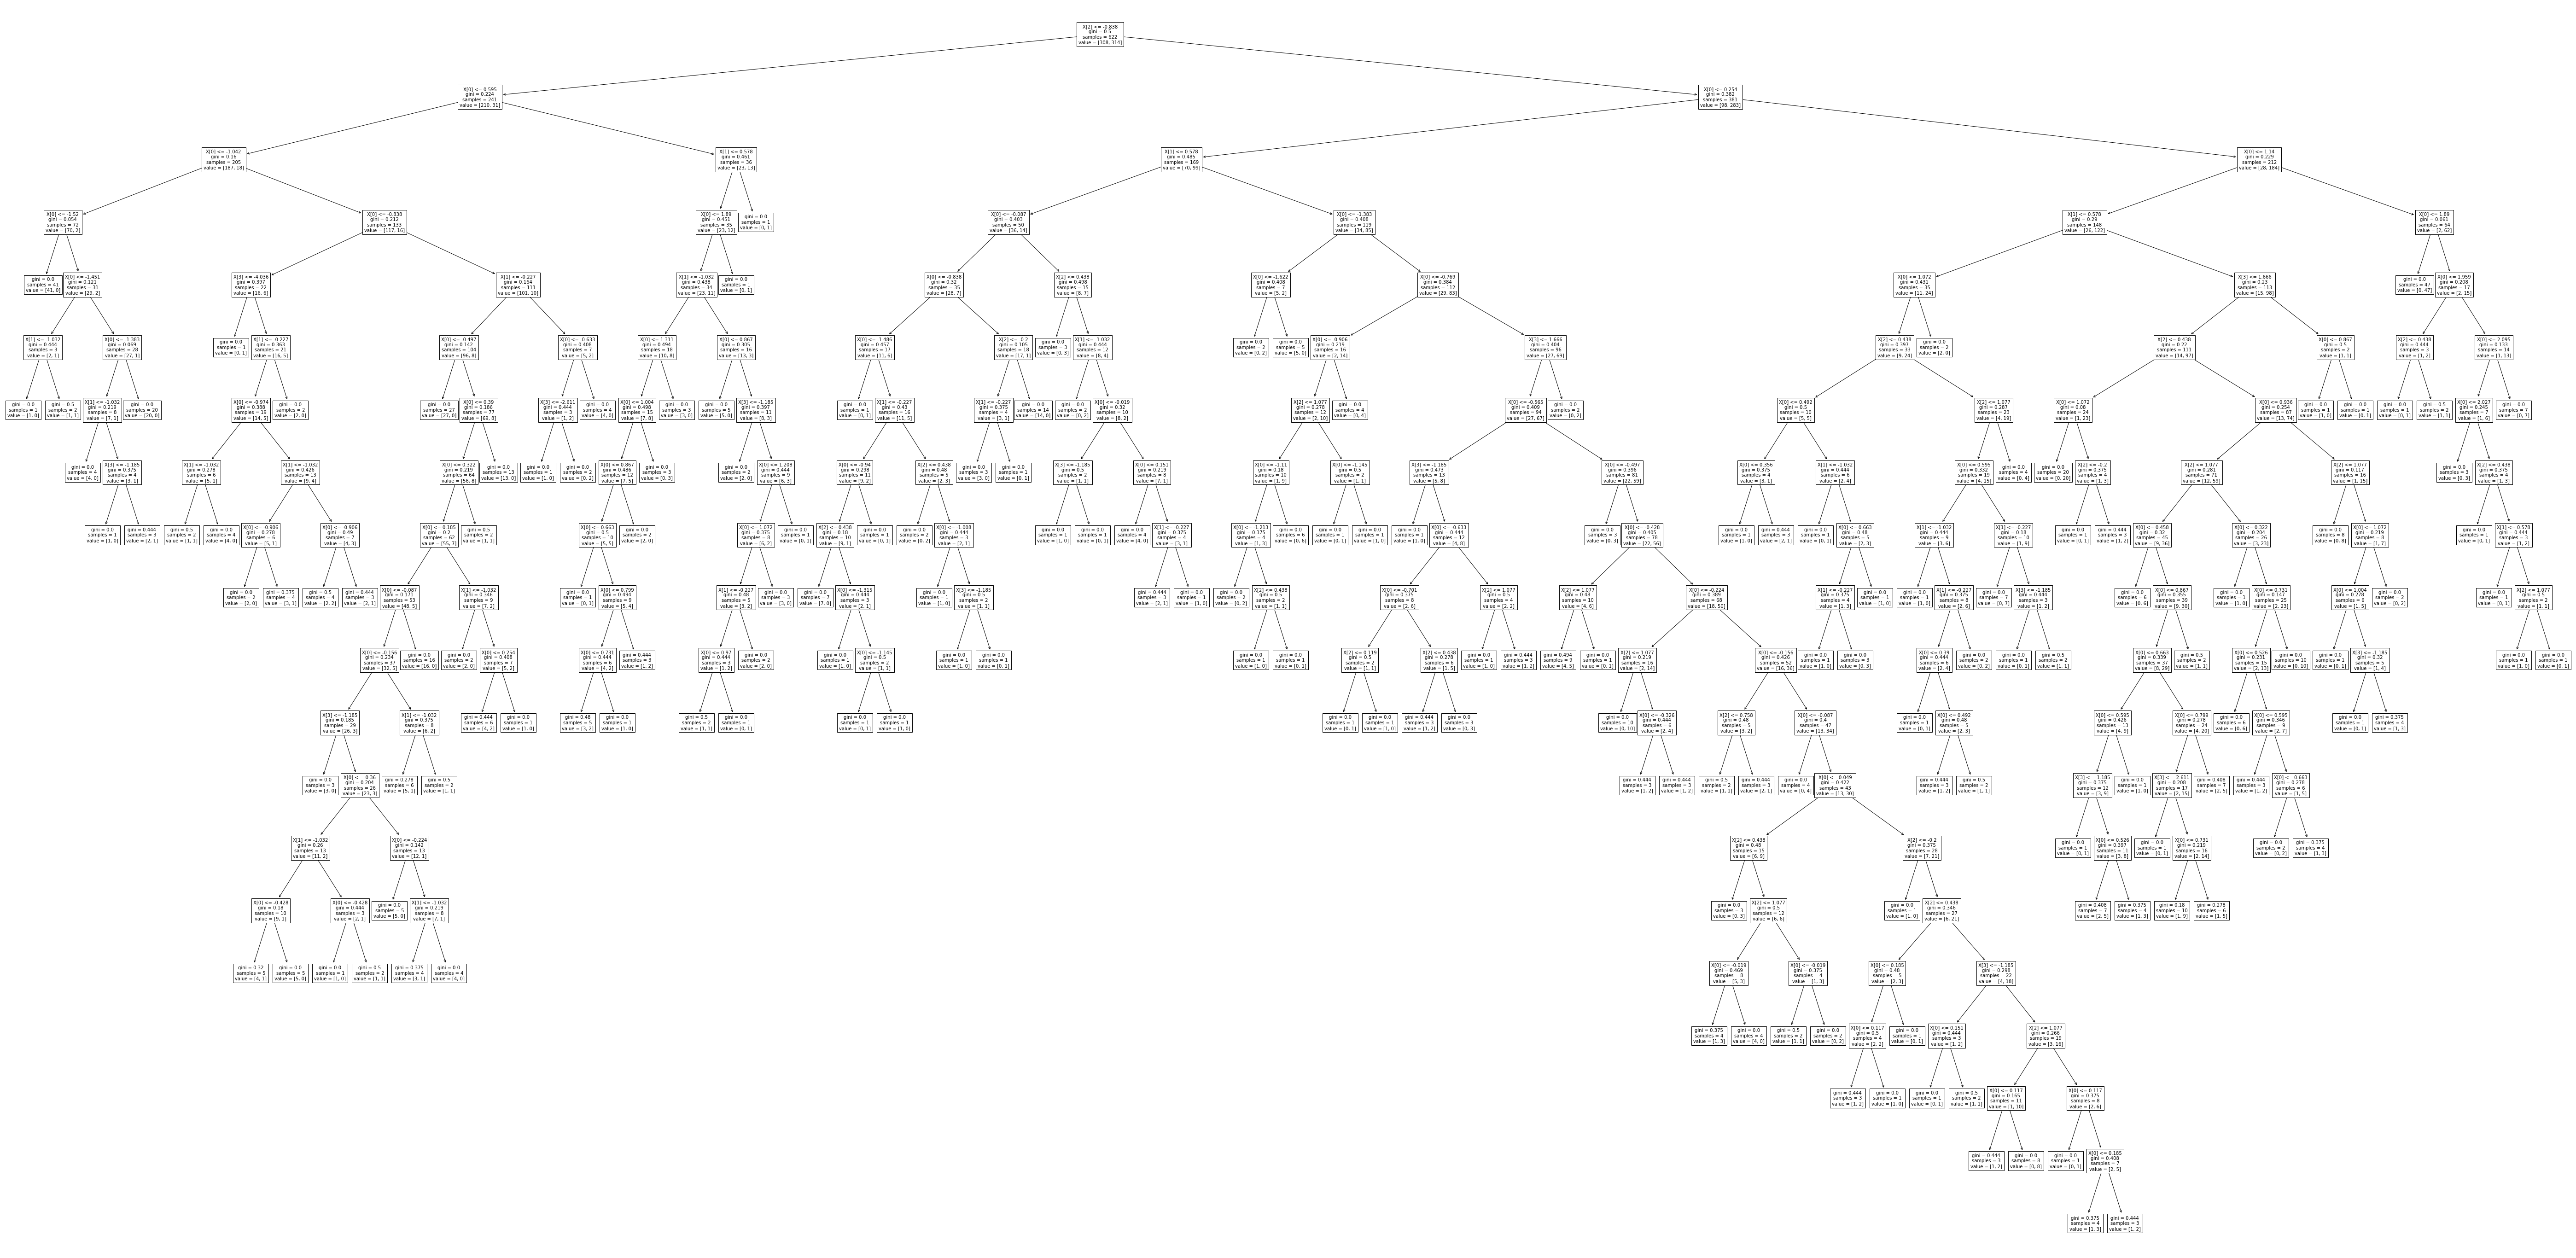

In [25]:
from sklearn import tree

# plot tree
plt.figure(figsize=(100, 50))  # set plot size (denoted in inches)
tree.plot_tree(clf, fontsize=10)
plt.show()

Measure the accuracy of the resulting decision tree model using test data

In [11]:
clf.score(X_test, y_test)

0.7355769230769231


### Use K-Fold cross validation to get better accuracy

In [28]:
from sklearn.model_selection import cross_val_score

clf = DecisionTreeClassifier(random_state=1)

cv_scores = cross_val_score(clf, features_value_scaled, classes, cv=10) # k = 10
cv_scores.mean()

0.7373493975903613

Try with a RandomForestClassifier

In [29]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=10, random_state=1)
cv_scores = cross_val_score(clf, features_value_scaled, classes, cv=10)

cv_scores.mean()

0.7421686746987952

## SVM

In [30]:
from sklearn import svm
C = 1.0

# Using linear Kernel
svc = svm.SVC(kernel='linear', C=C)

In [31]:
cv_scores = cross_val_score(svc, features_value_scaled, classes, cv=10)

cv_scores.mean()

0.7975903614457832

## KNN

In [34]:
from sklearn import neighbors

clf = neighbors.KNeighborsClassifier(n_neighbors=10)
cv_scores = cross_val_score(clf, features_value_scaled, classes, cv=10)

cv_scores.mean()

0.7915662650602409

Choosing an optimal K

In [35]:
for n in range(1, 50):
    clf = neighbors.KNeighborsClassifier(n_neighbors=n)
    cv_scores = cross_val_score(clf, features_value_scaled, classes, cv=10)
    print (n, cv_scores.mean())

1 0.7325301204819278
2 0.6903614457831325
3 0.7542168674698796
4 0.7349397590361446
5 0.7710843373493976
6 0.7686746987951807
7 0.7951807228915662
8 0.7771084337349398
9 0.7903614457831326
10 0.7915662650602409
11 0.7891566265060241
12 0.783132530120482
13 0.7879518072289157
14 0.7867469879518072
15 0.7867469879518072
16 0.7831325301204819
17 0.7783132530120482
18 0.7783132530120482
19 0.7843373493975904
20 0.7855421686746988
21 0.7879518072289156
22 0.7855421686746988
23 0.7783132530120481
24 0.7783132530120482
25 0.7867469879518072
26 0.7855421686746988
27 0.7855421686746988
28 0.7867469879518072
29 0.7855421686746988
30 0.7903614457831325
31 0.7867469879518072
32 0.789156626506024
33 0.7879518072289156
34 0.7867469879518072
35 0.7831325301204819
36 0.7867469879518072
37 0.7843373493975904
38 0.7867469879518072
39 0.7819277108433734
40 0.7843373493975904
41 0.780722891566265
42 0.7819277108433734
43 0.780722891566265
44 0.7819277108433734
45 0.7831325301204819
46 0.7843373493975904
4

## Naive Bayes

In [38]:
from sklearn.naive_bayes import MultinomialNB

scaler = preprocessing.MinMaxScaler()
all_features_minmax = scaler.fit_transform(features_value)

clf = MultinomialNB()
cv_scores = cross_val_score(clf, all_features_minmax, classes, cv=10)

cv_scores.mean()

0.7855421686746988

## Revisiting SVM

In [40]:
# Try with rbf kernal
C = 1.0
svc = svm.SVC(kernel='rbf', C=C)
cv_scores = cross_val_score(svc, features_value_scaled, classes, cv=10)
cv_scores.mean()

0.8012048192771084

In [42]:
# Try with sigmoid kernal
C = 1.0
svc = svm.SVC(kernel='sigmoid', C=C)
cv_scores = cross_val_score(svc, features_value_scaled, classes, cv=10)
cv_scores.mean()

0.7457831325301204

In [43]:
# Try with poly kernal
C = 1.0
svc = svm.SVC(kernel='poly', C=C)
cv_scores = cross_val_score(svc, features_value_scaled, classes, cv=10)
cv_scores.mean()

0.7903614457831326

## Logistic Regression

In [44]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
cv_scores = cross_val_score(clf, features_value_scaled, classes, cv=10)
cv_scores.mean()

0.8072289156626505

## Do we have a winner?

Which model, and which choice of hyperparameters, performed the best?

#### The only is decision trees have the lowest accuracy with 73%! Every other algorithm produce better results with 79-80% accuracy.